<a href="https://colab.research.google.com/github/albertchen0286/Dog-Breed-Classification/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Breed Classification

Wenxuan Yan, Zi Yuan Li, Yen-Chun Chen

# import data

In [ ]:
#import library
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, MaxPool2D
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import os
from google.colab import drive
import matplotlib.pyplot as plt


In [ ]:
#mount drive
drive.mount('/content/drive')
#directory
image_dir = '/content/drive/Shareddrives/ba865_final/images/Images'
annotation_dir = "/content/drive/Shareddrives/ba865_final/Annotation"
data_folder = '/content/drive/Shareddrives/ba865_final/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# data preprocess

In [ ]:
#two file for image list
import scipy.io
test_data = scipy.io.loadmat(data_folder + 'test_data.mat')
train_data = scipy.io.loadmat(data_folder + 'train_data.mat')

In [ ]:
#check for later preprocess
print("Keys in train_data:", train_data.keys())
print("Keys in test_data:", test_data.keys())


Keys in train_data: dict_keys(['__header__', '__version__', '__globals__', 'train_info', 'train_fg_data', 'train_data'])
Keys in test_data: dict_keys(['__header__', '__version__', '__globals__', 'test_info', 'test_fg_data', 'test_data'])


In [ ]:
print("Shape of train_data:", train_data['train_data'].shape)
print("Shape of train_info:", train_data['train_info'].shape)
print("Shape of test_data:", test_data['test_data'].shape)
print("Shape of test_info:", test_data['test_info'].shape)

Shape of train_data: (12000, 12000)
Shape of train_info: (1, 1)
Shape of test_data: (8580, 12000)
Shape of test_info: (1, 1)


In [ ]:
print("Content of train_info:", train_data['train_info'])
print("Content of test_info:", test_data['test_info'])

Content of train_info: [[(array([[array(['n02085620-Chihuahua/n02085620_5927.jpg'], dtype='<U38')],
         [array(['n02085620-Chihuahua/n02085620_4441.jpg'], dtype='<U38')],
         [array(['n02085620-Chihuahua/n02085620_1502.jpg'], dtype='<U38')],
         ...,
         [array(['n02116738-African_hunting_dog/n02116738_6754.jpg'], dtype='<U48')],
         [array(['n02116738-African_hunting_dog/n02116738_9333.jpg'], dtype='<U48')],
         [array(['n02116738-African_hunting_dog/n02116738_2503.jpg'], dtype='<U48')]],
        dtype=object), array([[array(['n02085620-Chihuahua/n02085620_5927'], dtype='<U34')],
         [array(['n02085620-Chihuahua/n02085620_4441'], dtype='<U34')],
         [array(['n02085620-Chihuahua/n02085620_1502'], dtype='<U34')],
         ...,
         [array(['n02116738-African_hunting_dog/n02116738_6754'], dtype='<U44')],
         [array(['n02116738-African_hunting_dog/n02116738_9333'], dtype='<U44')],
         [array(['n02116738-African_hunting_dog/n02116738_25

In [ ]:
#load data function
import numpy as np
import pandas as pd
import scipy.io

def load_data(data_folder, image_dir):
    train_data = scipy.io.loadmat(data_folder + 'train_data.mat')
    test_data = scipy.io.loadmat(data_folder + 'test_data.mat')

    train_info = train_data['train_info'][0][0]
    test_info = test_data['test_info'][0][0]

    train_filenames = np.squeeze(train_info[0])
    train_class_ids = np.squeeze(train_info[2])
    test_filenames = np.squeeze(test_info[0])
    test_class_ids = np.squeeze(test_info[2])

    train_list = pd.DataFrame({'filename': train_filenames, 'class_id': train_class_ids})
    test_list = pd.DataFrame({'filename': test_filenames, 'class_id': test_class_ids})

    train_list['filename'] = train_list['filename'].apply(lambda x: x[0])
    test_list['filename'] = test_list['filename'].apply(lambda x: x[0])

    train_list['class_id'] = train_list['class_id'].apply(lambda x: str(x).zfill(3))
    test_list['class_id'] = test_list['class_id'].apply(lambda x: str(x).zfill(3))

    return train_list, test_list

train_list, test_list = load_data(data_folder, image_dir)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

#define data generators
img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

#update data generators
train_generator = train_datagen.flow_from_dataframe(dataframe=train_list,
                                                    directory=image_dir,
                                                    x_col='filename',
                                                    y_col='class_id',
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_dataframe(dataframe=train_list,
                                                         directory=image_dir,
                                                         x_col='filename',
                                                         y_col='class_id',
                                                         target_size=(img_size, img_size),
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         subset='validation')

test_generator = test_datagen.flow_from_dataframe(dataframe=test_list,
                                                  directory=image_dir,
                                                  x_col='filename',
                                                  y_col='class_id',
                                                  target_size=(img_size, img_size),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 2400 validated image filenames belonging to 30 classes.
Found 600 validated image filenames belonging to 30 classes.
Found 2448 validated image filenames belonging to 30 classes.


# descriptive statistics for dataset

In [ ]:
#we selelct top 30 popular breed since 120 classes gonna take way to long to run the model.
top_breeds = ['Chihuahua', 'beagle', 'Boston_bull', 'Afghan_hound', 'Labrador_retriever', 'golden_retriever',
              'Border_collie', 'German_shepherd', 'Shih-Tzu', 'French_bulldog', 'Doberman', 'Bernese_mountain_dog',
              'malamute', 'Pomeranian', 'Saint_Bernard', 'Siberian_husky', 'pug', 'Samoyed', 'Yorkshire_terrier',
              'briard', 'whippet', 'bluetick', 'basset', 'papillon', 'redbone', 'cairn', 'Lhasa', 'clumber',
              'malinois', 'chow']

breed_id_mapping = {breed: str(idx + 1).zfill(3) for idx, breed in enumerate(top_breeds)}

#filter train_list and test_list
train_list = train_list[train_list['class_id'].isin(breed_id_mapping.values())]
test_list = test_list[test_list['class_id'].isin(breed_id_mapping.values())]

In [ ]:
#statistics
import pandas as pd

#training set
train_class_counts = train_list['class_id'].value_counts()
train_class_distribution = train_class_counts / len(train_list)

print("Training set class distribution:")
print(train_class_distribution)

#test set
test_class_counts = test_list['class_id'].value_counts()
test_class_distribution = test_class_counts / len(test_list)

print("\nTest set class distribution:")
print(test_class_distribution)

Training set class distribution:
001    0.033333
002    0.033333
029    0.033333
028    0.033333
027    0.033333
026    0.033333
025    0.033333
024    0.033333
023    0.033333
022    0.033333
021    0.033333
020    0.033333
019    0.033333
018    0.033333
017    0.033333
016    0.033333
015    0.033333
014    0.033333
013    0.033333
012    0.033333
011    0.033333
010    0.033333
009    0.033333
008    0.033333
007    0.033333
006    0.033333
005    0.033333
004    0.033333
003    0.033333
030    0.033333
Name: class_id, dtype: float64

Test set class distribution:
003    0.062092
010    0.056781
027    0.053922
020    0.048203
005    0.046569
026    0.040850
024    0.039216
007    0.039216
012    0.038807
023    0.035948
006    0.035948
022    0.035539
013    0.035539
002    0.034722
021    0.033497
011    0.030637
009    0.029412
008    0.029412
014    0.029003
030    0.026144
028    0.024510
015    0.024101
017    0.023284
029    0.022467
016    0.021650
001    0.021242
025    0.0

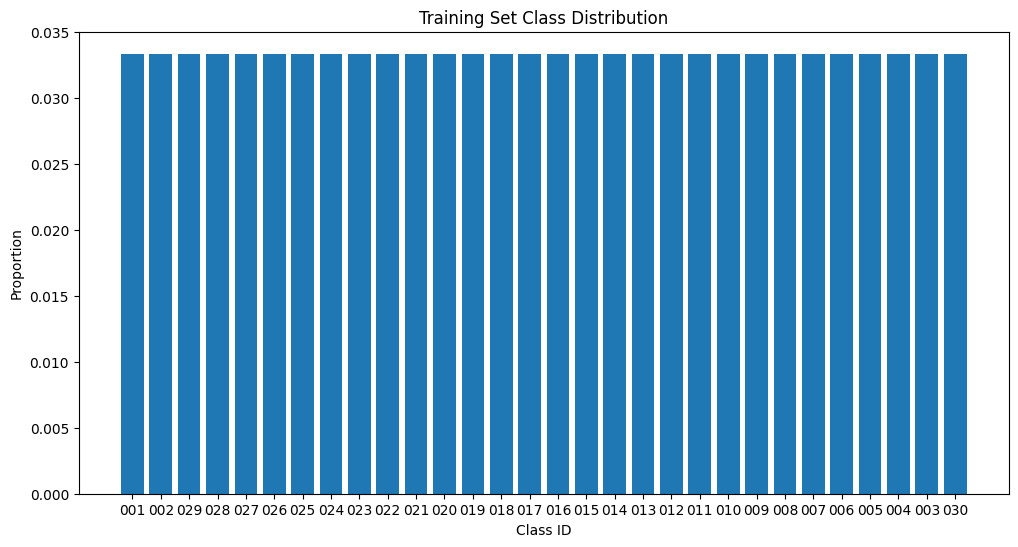

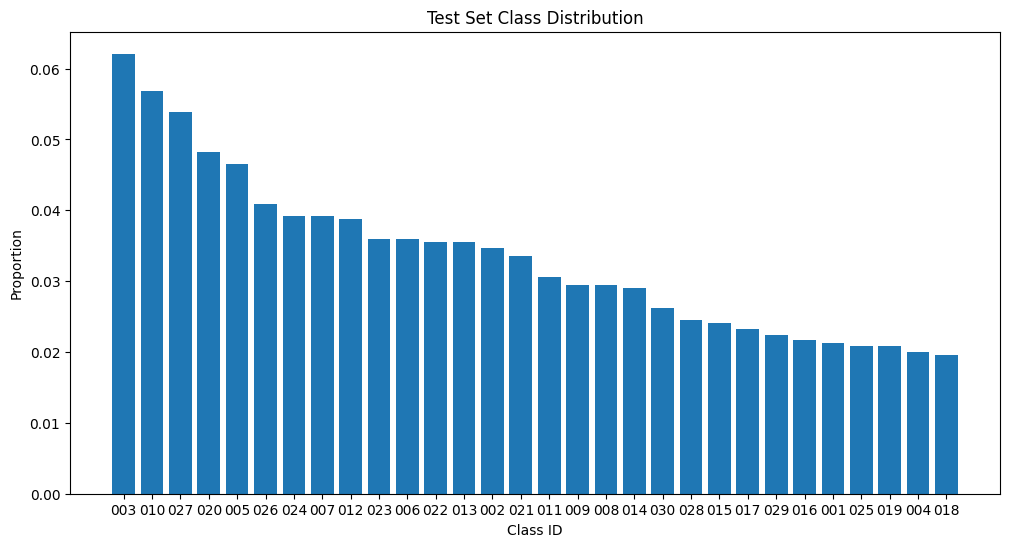

In [ ]:
#graph for class imbalance if there is any
import matplotlib.pyplot as plt

def plot_class_distribution(class_distribution, title):
    plt.figure(figsize=(12, 6))
    plt.bar(class_distribution.index, class_distribution.values)
    plt.xlabel('Class ID')
    plt.ylabel('Proportion')
    plt.title(title)
    plt.show()

plot_class_distribution(train_class_distribution, 'Training Set Class Distribution')
plot_class_distribution(test_class_distribution, 'Test Set Class Distribution')

# implement NN architecture

In [ ]:
#build the model
model = Sequential()
#using maxpool to reduce the spatial dimensions
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(7, 7), activation='relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=8, kernel_size=(5, 5), activation='relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation="relu", kernel_regularizer='l2'))
model.add(Dense(64, activation="relu", kernel_regularizer='l2'))
model.add(Dense(len(train_generator.class_indices), activation="softmax")) #softmax since is multiclass
#set learning rate to 0.0001 to ensure a balance between convergence speed and model stability
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])#using categorical crossentropy for the same reason

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 16)       0

In [ ]:
#using early stopping to avoid overfitting
from keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
    ModelCheckpoint(
        filepath="DogBreedModel_Sequential.keras",
        save_best_only=True,
        monitor="val_loss"),
    EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True)
]

# fit the model

In [ ]:
history = model.fit(
    train_generator,
    epochs=30, #set to 30 because it tooks too long to run each epoch
    validation_data=validation_generator,
    callbacks=callbacks)

Epoch 1/30
75/75 [==============================] - 516s 7s/step - loss: 5.4168 - accuracy: 0.0533 - val_loss: 7.9700 - val_accuracy: 0.0000e+00
Epoch 2/30
75/75 [==============================] - 491s 7s/step - loss: 5.0587 - accuracy: 0.0546 - val_loss: 8.3841 - val_accuracy: 0.0000e+00
Epoch 3/30
75/75 [==============================] - 524s 7s/step - loss: 4.7686 - accuracy: 0.0592 - val_loss: 8.9024 - val_accuracy: 0.0000e+00
Epoch 4/30
75/75 [==============================] - 522s 7s/step - loss: 4.5577 - accuracy: 0.0604 - val_loss: 9.0218 - val_accuracy: 0.0000e+00
Epoch 5/30
75/75 [==============================] - 520s 7s/step - loss: 4.3808 - accuracy: 0.0533 - val_loss: 8.6564 - val_accuracy: 0.0000e+00
Epoch 6/30
75/75 [==============================] - 504s 7s/step - loss: 4.2418 - accuracy: 0.0625 - val_loss: 8.3024 - val_accuracy: 0.0000e+00
Epoch 7/30
75/75 [==============================] - 492s 7s/step - loss: 4.1300 - accuracy: 0.0567 - val_loss: 9.1457 - val_accura

# evaluate the test performance

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

77/77 [==============================] - 721s 9s/step - loss: 5.8516 - accuracy: 0.0429
Test loss: 5.851579666137695
Test accuracy: 0.04289215803146362


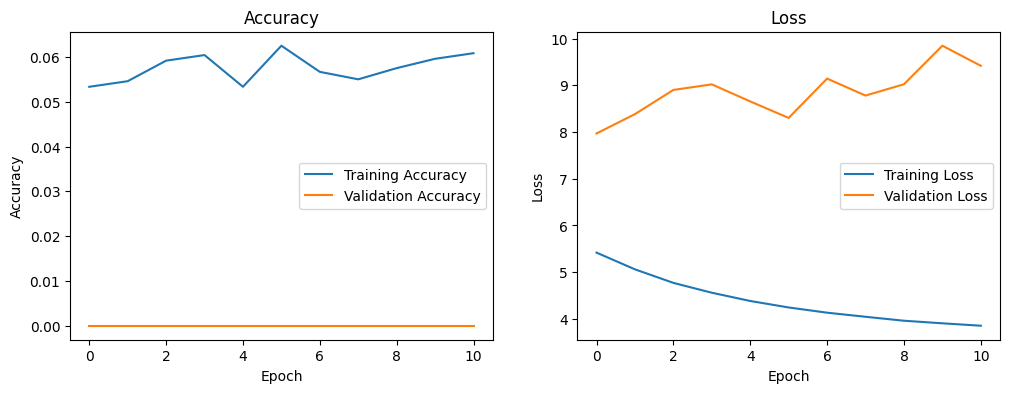

In [ ]:
import matplotlib.pyplot as plt
#plot the model performance
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)


# pre-trained model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#load pre-trained model
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
base_model.trainable = False

#add new classifier layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    epochs=10,#set 10
    validation_data=validation_generator
)

score = model.evaluate(test_generator)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/10
75/75 [==============================] - 2022s 27s/step - loss: 3.6616 - accuracy: 0.0696 - val_loss: 6.5825 - val_accuracy: 0.0000e+00
Epoch 2/10
75/75 [==============================] - 2018s 27s/step - loss: 2.9347 - accuracy: 0.1442 - val_loss: 10.8059 - val_accuracy: 0.0000e+00
Epoch 3/10
75/75 [==============================] - 2042s 27s/step - loss: 2.6629 - accuracy: 0.1992 - val_loss: 12.7393 - val_accuracy: 0.0000e+00
Epoch 4/10
75/75 [==============================] - 2195s 29s/step - loss: 2.5221 - accuracy: 0.2375 - val_loss: 13.5646 - val_accuracy: 0.0000e+00
Epoch 5/10
75/75 [==============================] - 1975s 26s/step - loss: 2.3513 - accuracy: 0.2917 - val_loss: 14.3703 - val_accuracy: 0.0000e+00
Epoch 6/10
75/75 [==============================] - 2027s 27s/step - loss: 2.2726 - accuracy: 0.3004 - val_loss: 16.5800 - val_accuracy: 0.0000e+00
Epoch 7/10
75/75 [==============================

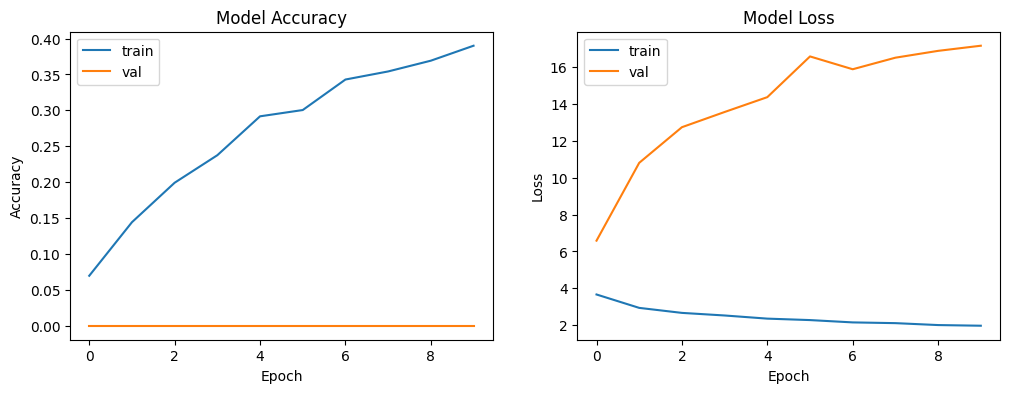

In [ ]:
#plot performance
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Example

1/1 [==============================] - 1s 1s/step


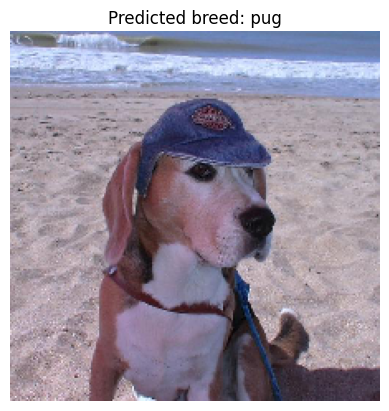

In [ ]:
#decode the prediction
def get_breed_name(class_index, breed_id_mapping):
    for breed, idx in breed_id_mapping.items():
        if str(class_index + 1).zfill(3) == idx:
            return breed
    return None

#test the model with an example dog photo
img_path = '/content/drive/Shareddrives/ba865_final/images/Images/n02088364-beagle/n02088364_12397.jpg'
target_size = (img_size, img_size)

class_index = predict_dog_breed(img_path, model, target_size)
breed_name = get_breed_name(class_index, breed_id_mapping)

#display the image and the prediction
img = image.load_img(img_path, target_size=target_size)
plt.imshow(img)
plt.title(f"Predicted breed: {breed_name}")
plt.axis("off")
plt.show()


1/1 [==============================] - 1s 936ms/step


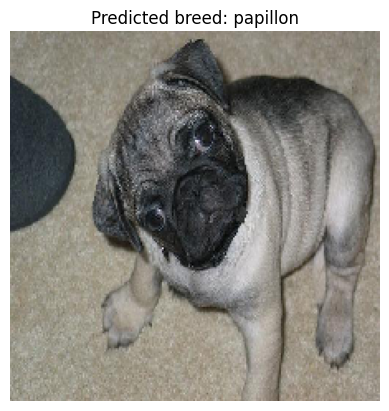

In [ ]:
#decode the prediction
def get_breed_name(class_index, breed_id_mapping):
    for breed, idx in breed_id_mapping.items():
        if str(class_index + 1).zfill(3) == idx:
            return breed
    return None

#test the model with an example dog photo
img_path = '/content/drive/Shareddrives/ba865_final/images/Images/n02110958-pug/n02110958_14996.jpg'
target_size = (img_size, img_size)

class_index = predict_dog_breed(img_path, model, target_size)
breed_name = get_breed_name(class_index, breed_id_mapping)

#display the image and the prediction
img = image.load_img(img_path, target_size=target_size)
plt.imshow(img)
plt.title(f"Predicted breed: {breed_name}")
plt.axis("off")
plt.show()


# future work and suggestion

As the model performance and example shows, our model performance still has lots of room to improve. We need more complex model and more training picture in order to have a more accurate model. Also we can apply residual connection in the future or adjust learning rate, batch size and epoch step.

# Work Citation

ChatGPT and Stackoverflow

chat history can be found in the path:
'/content/drive/Shareddrives/ba865_final/chat.html/'